In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import time
import pickle
import sys
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf                                                                                                                                                                                                                  
import h5py
from scipy.signal import find_peaks

fname='1630519596' # block number
data=kio.load_data(fname) # somehow this knows the folder where the file is picks the scan part only (only picks out the scan no track and slew)


# just to make sure we don't use some bad dish
target,c0,bad_ants,flux_model=kio.check_ants(fname)

ants_good=[]
for i in np.array(kio.ant_list(data)):
    if i not in bad_ants:
        ants_good.append(i)
    else:
        print (str(i) + ' is bad')
print (fname)
print (ants_good)



#select ant and polarization
ant='m000'
pol='h'



#load data, labels, and parameters

data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
print(corr_id)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])


print (corr_id,recv)

vis,flags= kio.call_vis(fname,recv)
print(vis.copy().shape)
vis_backup=vis.copy()

#print(vis_backup['corr_id'].shape)


#we need all this complicated stuff to get the noise diode positions in the data...
ch_ref=800

dump_period=data.dump_period
timestamps,freqs=kio.load_tf(data)


nd_on_time,nd_cycle,nd_set=kd.cal_nd_basic_para(fname)

#this is how we know what is track, slew and scan data
ra,dec,az,el=kio.load_coordinates(data)
ang_deg=kio.load_ang_deg(ra,dec,c0)
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)

#edge of noise diode;s
nd_on_edge,nd_off_edge=kd.cal_nd_edges(timestamps,nd_set,nd_cycle,nd_on_time)
nd_ratio,nd_0, nd_1x=kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, dump_period)

#see where the data is track AND ND_on or ND_off and the same for survey 
nd_t0,nd_t1x,nd_s0,nd_s1x,nd_t0_ca,nd_t0_cb,nd_t1x_ca,nd_t1x_cb=kl.cal_label_intersec(dp_tt,dp_ss,nd_0,nd_1x)


calibrator: PKS1934-638, ra,dec= 294d51m15.39s, -63d42m45.6264s
bad_ants: []
1630519596
['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm023', 'm024', 'm025', 'm027', 'm029', 'm030', 'm031', 'm032', 'm033', 'm034', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm052', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063']
0
0 m000h
# loaded data was saved in python2
['m000h' 'm000h']
(3647, 4096)
edge number 0-374
*** diode 0 was fired out of timestamps list: -17.06315779685974 not in [0,7288.9163699150085]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


In [2]:
data = vis.copy()

def MaskedArrayVisibilityFlags(vis, flags, nd_s0):
    """
    * Created a masked array
    Reason for creating a masked array of the TOD: 

    Parameters:
    ----------
    visibility, flags and nd_s0 from the visData Fuction.

    Returns:
    --------
    Visibility-Flags Masked Array
    """
    #vis, flags, nd_s0 = visData(fname)
    
    data0 = vis.copy
    

    nd_flags = np.ones_like(vis, dtype=bool)          # Empty mask, where all values are set to true. True is flagged data
    nd_flags[nd_s0, :] = False                        # Set the data with noise diodes removed to False so that this data is not flagged as bad data.  This is the scan only data.
    other_flags = flags                               # All other flags from the visData function. Boolean value is True.
    allflags =  np.logical_or(nd_flags, other_flags)  # Apply logical operator or to combine the noise diode flags, and visilibity data at a specific stage flags. 

    data_masked = np.ma.masked_array(vis, mask=allflags, fill_value = np.nan)

    return data_masked

def abba(array: np.ndarray):
    """Calculate ABBA dithering (interpolation) from a 1D array (time series).
    
    Parameters
    -------
    array: np.ndarray
        Numpy array of visibility as a function of time dump.
        Can be masked array (np.nan will be propagated)

    Returns
    -------
    out: ndarray after ABBA (shape N-3)
    """
    return (array[1:-2]+array[2:-1])/2 - (array[0:-3]+array[3:])/2

def plot_bandpass(x : np.ndarray, y : np.ndarray, label=None, ylim : tuple = None, figsize=(8, 3), ax=None):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(x, y, label=label)
    if ylim is not None:
        ax.set_ylim(*ylim)
    return ax


def SkySubtraction(data_masked):

    """
    Function Returns differencing of the  visibility masked array.
    """

    vis_ss =data_masked[1:,:] - data_masked[0:-1,:]
   

    return vis_ss

# ABBA sky-subtraction of observation block 1630519596 

data_masked = MaskedArrayVisibilityFlags(data, flags, nd_s0)


def plot_bandpass1(x_or_y: np.ndarray, label=None, ylim: tuple = None, figsize=(8, 3), ax=None):
    """Plot bandpass (visibility vs frequency channel)"""
    if ax is None:  # Create a new figure and axes if not being passed in as a parameter
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    if label is not None:
        ax.plot(x_or_y, label=label)
    else:
        ax.plot(x_or_y)

    if ylim is not None:
        ax.set_ylim(*ylim)

    return ax


In [74]:
mss = SkySubtraction(data)

In [3]:
data = data_masked[1010:1030, 3001].filled()

In [32]:
#Polynomial Fit of Raw Visibilities

from numpy.polynomial import Polynomial
data = data_masked[1010:1030, 3001].filled()

missing_data =np.isnan(data) #missing data that we interpolate for the polynomial to fit 
datapoints = np.arange(len(data)) #missing data point indices that we want the polynomial to fit 
polynomial = Polynomial.fit(datapoints[~missing_data], data[~missing_data], deg=1)
data[missing_data] = polynomial(datapoints[missing_data])


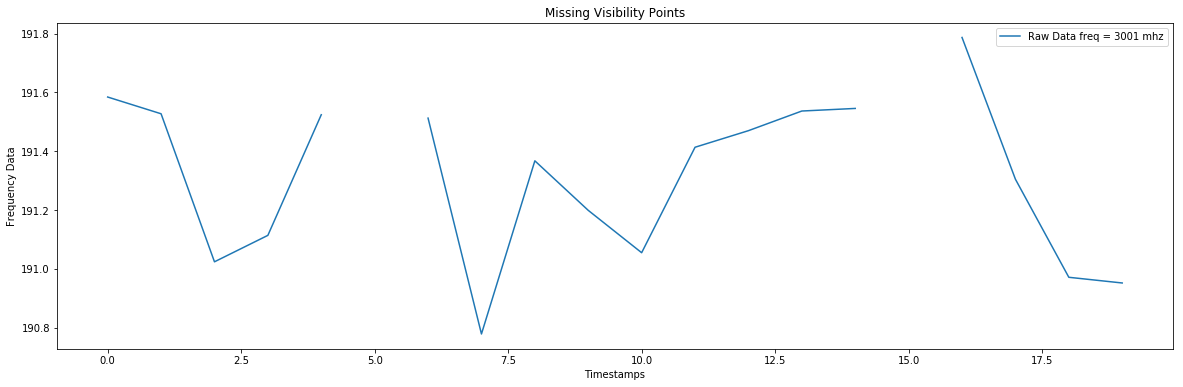

In [42]:
#inspecting a section  visibility data, data = data_masked[1010:1030, 3001].filled()

plt.figure(figsize=(20,6))
plt.title('Missing Visibility Points')
plt.plot(data, label='Raw Data freq = 3001 mhz')
plt.xlabel('Timestamps')
plt.ylabel('Frequency Data')
#plt.ylim(-100,100)
plt.legend()
plt.show()

In [43]:
#polynomial fit without interpolating
datapoints = np.arange(len(data))
poly = Polynomial.fit(datapoints, data, deg=15)


In [45]:
#polynomial fit without interpolating
datapoints = np.arange(len(data))
poly = Polynomial.fit(datapoints, data, deg=15)


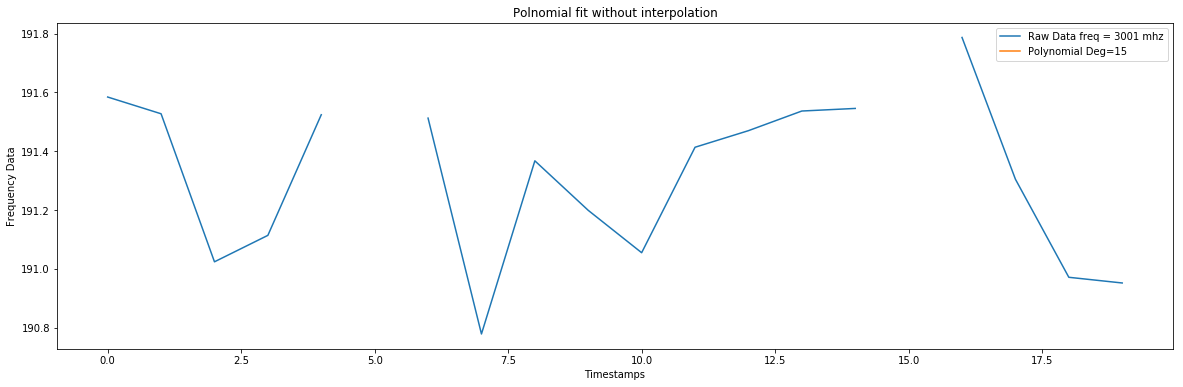

In [47]:
#polynomial fit without interpolation data
plt.figure(figsize=(20,6))
plt.title('Polnomial fit without interpolation')
plt.plot(data, label='Raw Data freq = 3001 mhz')
plt.plot(datapoints, poly(datapoints), label='Polynomial Deg=15')
plt.xlabel('Timestamps')
plt.ylabel('Frequency Data')
#plt.ylim(-100,100)
plt.legend()
plt.show()

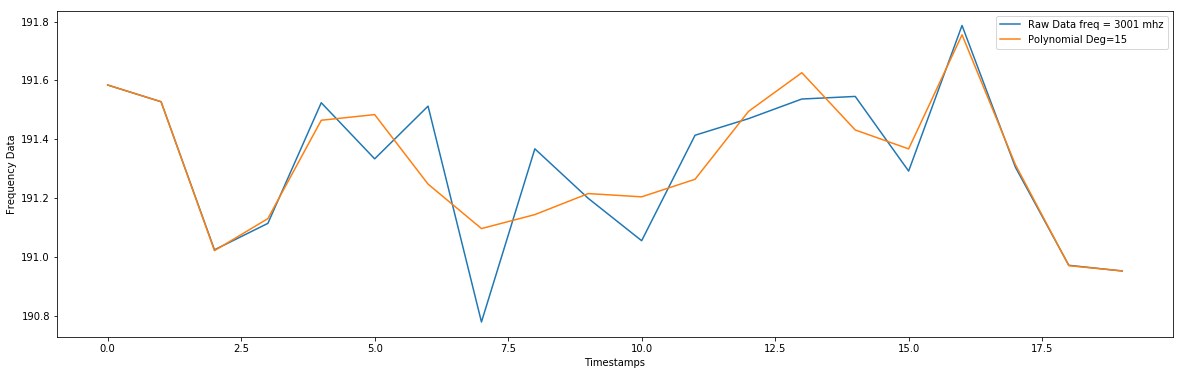

In [38]:
#polynomial fit data
plt.figure(figsize=(20,6))
plt.plot(data, label='Raw Data freq = 3001 mhz')
plt.plot(datapoints, poly(datapoints), label='Polynomial Deg=15')
plt.xlabel('Timestamps')
plt.ylabel('Frequency Data')
#plt.ylim(-100,100)
plt.legend()
plt.show()

In [ ]:
#inspecting the channels that have the gain fluctuations

In [68]:
#x.shape
#x[0:,:].shape 
#x[:-1,:].shape
difference = x[1:,:] - x[:-1,:] #difference bettwen the first and last

In [77]:
#Polynomial fitting handling the nans
from numpy.polynomial import Polynomial
degree = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
data = data_masked[1010:1030, 3001].filled()
mean_values = np.nanmean(data, axis=0)
data = np.nan_to_num(data, nan=mean_values)
datapoints = np.arange(len(data))
valid_data = np.isfinite(data)

y = data[valid_data]
x = datapoints[valid_data]
p = Polynomial.fit(x, y, deg=15)

R2_score =0.7523725964735578 for deg:15
R2_score =0.7612171201234741 for deg:16
R2_score =0.8772106311094339 for deg:17
R2_score =0.9900091286391702 for deg:18
R2_score =1.0 for deg:19
R2_score =1.0 for deg:20
R2_score =1.0 for deg:21
R2_score =1.0 for deg:22


/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


R2_score =1.0 for deg:23
R2_score =1.0 for deg:24
R2_score =1.0 for deg:25


/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


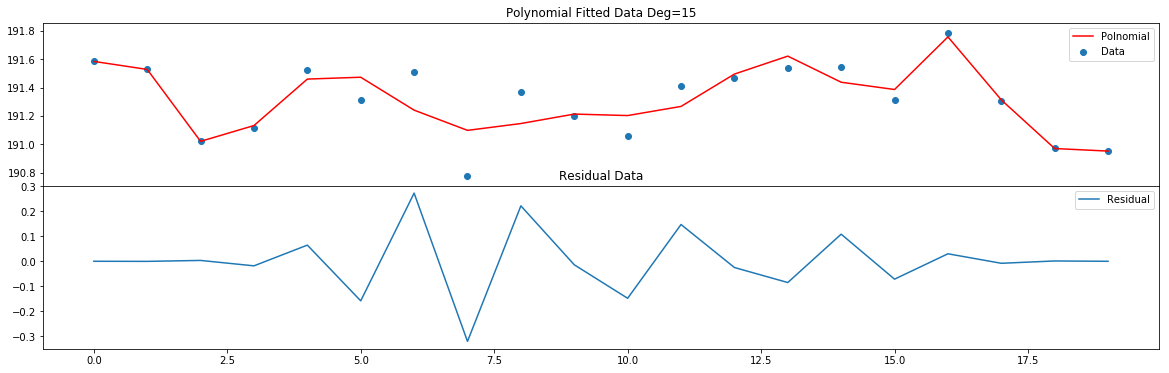

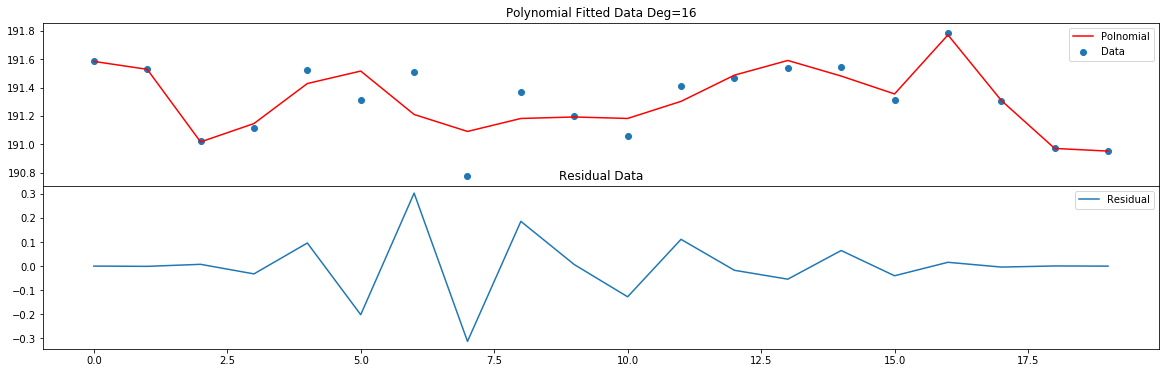

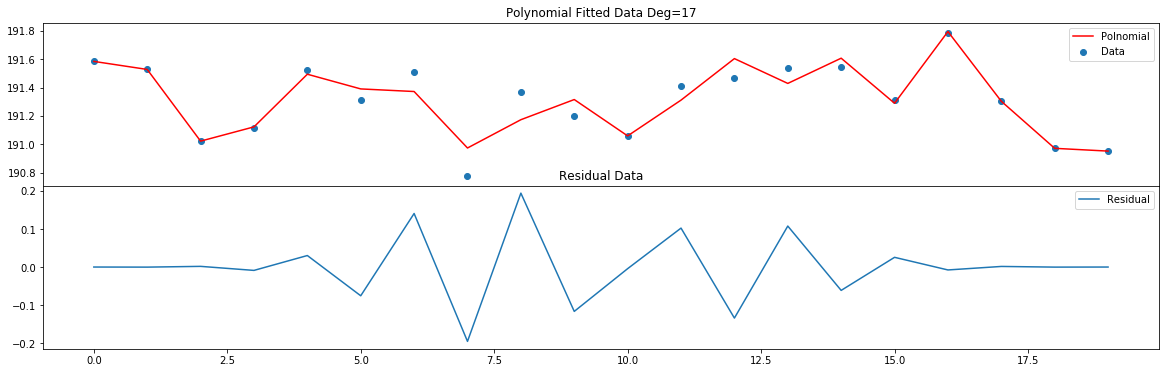

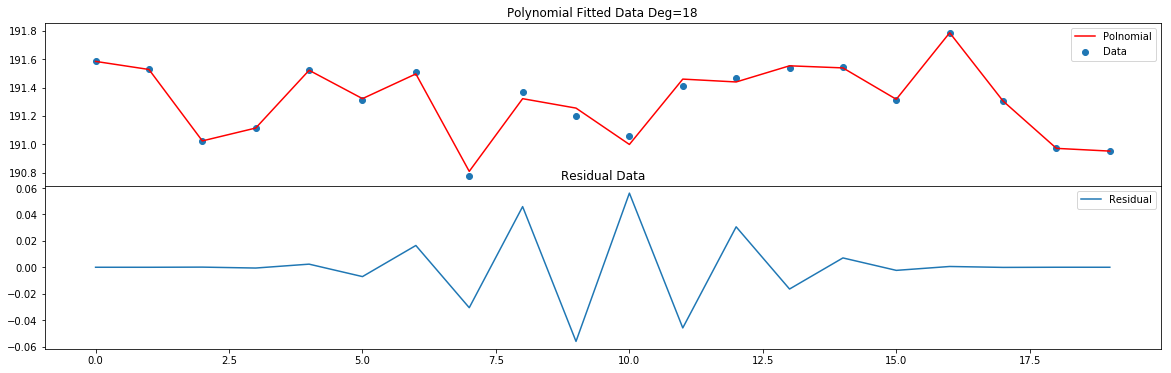

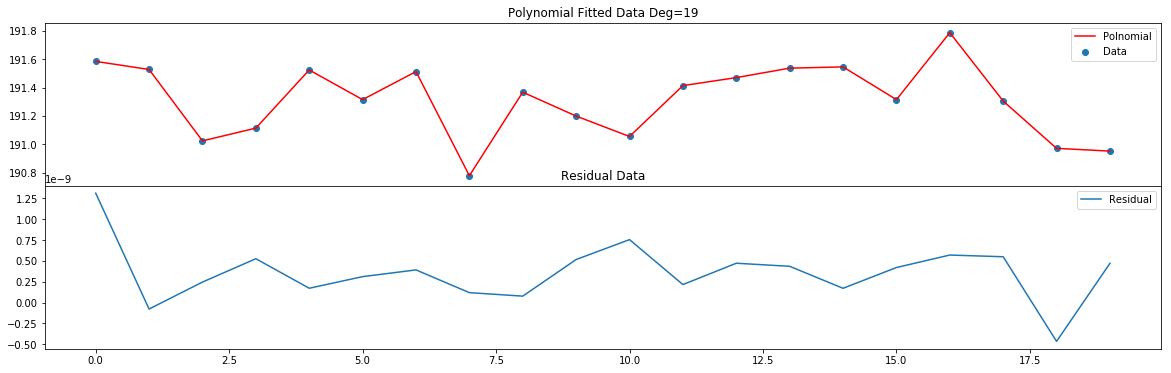

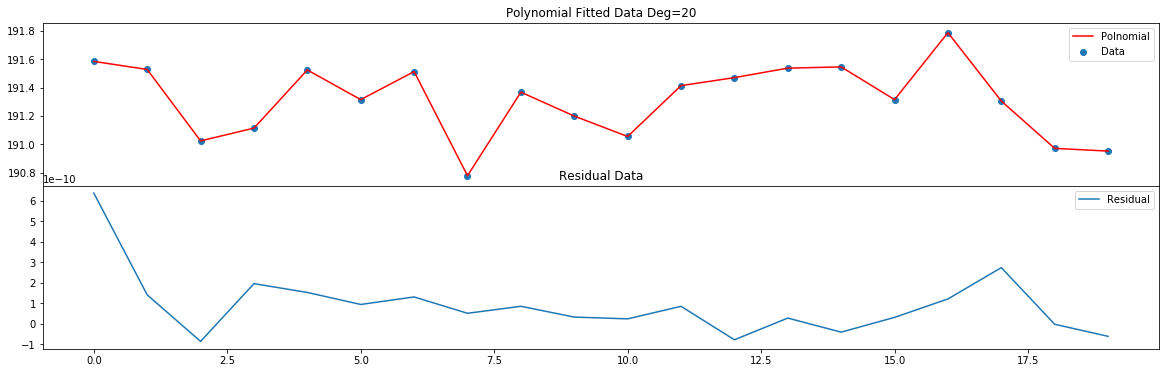

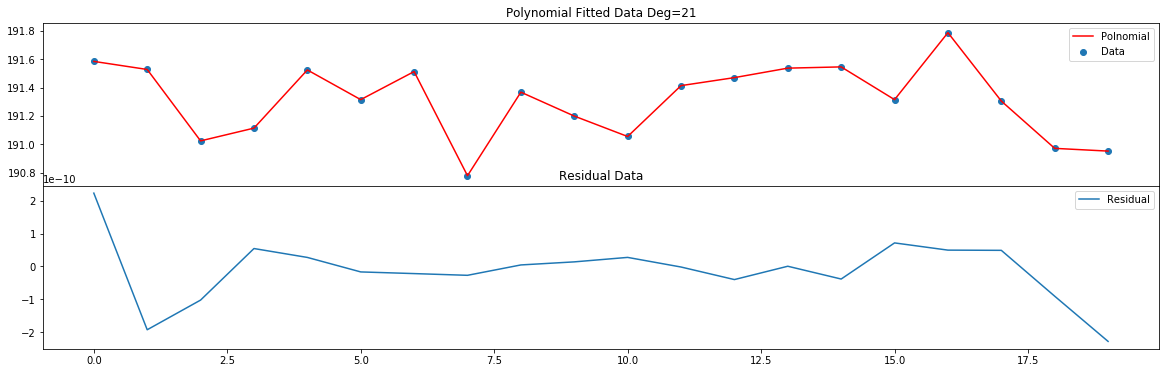

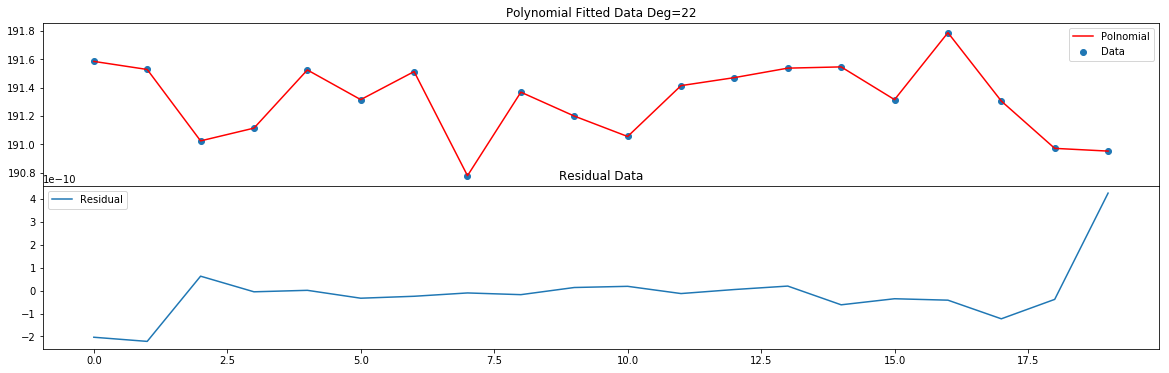

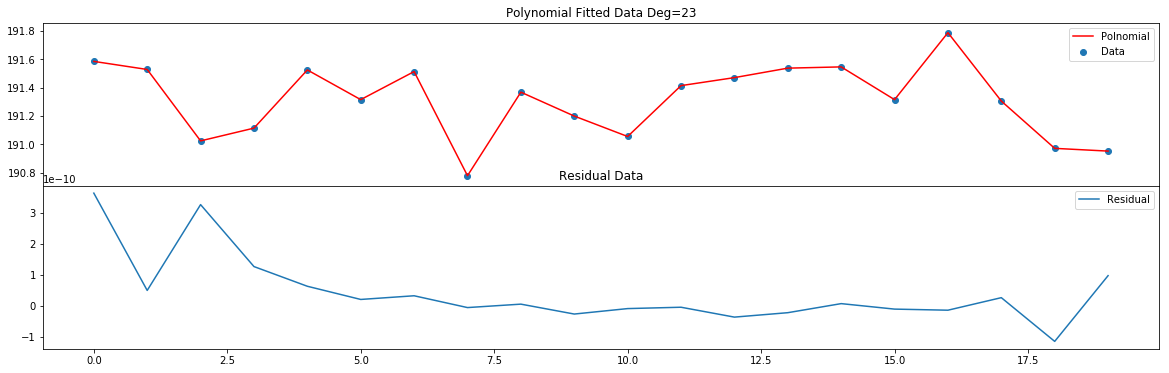

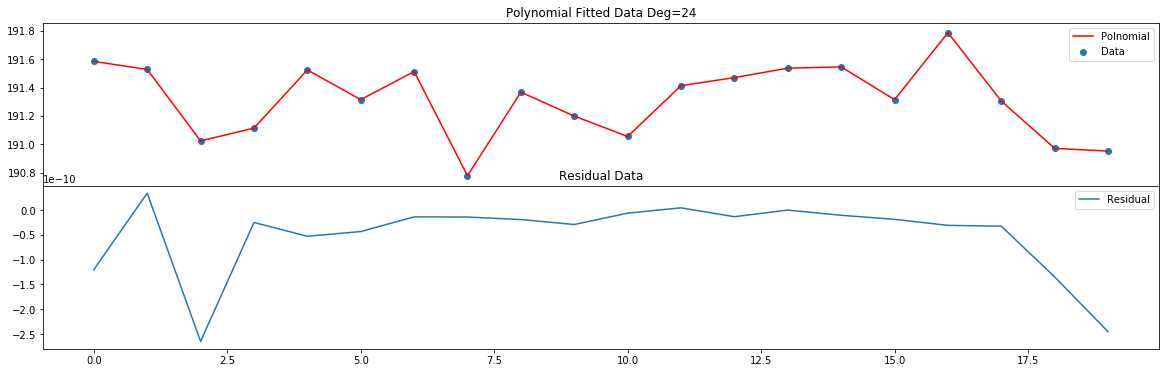

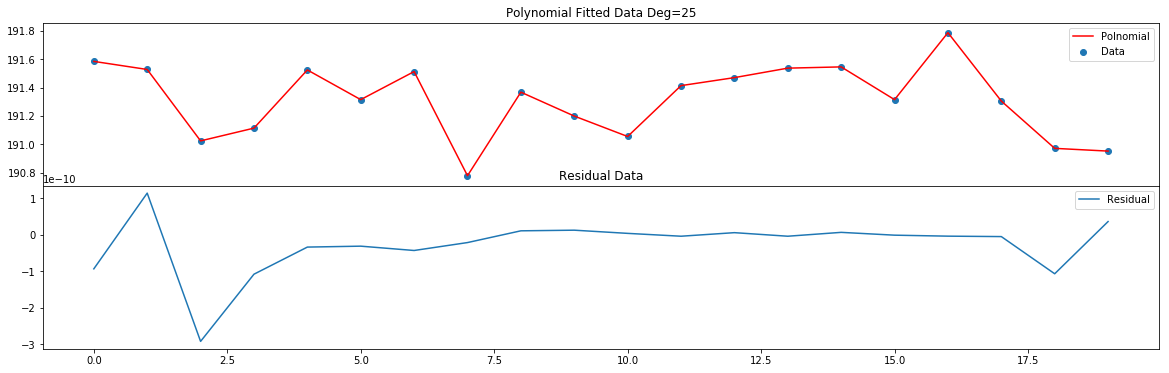

In [78]:
for deg in degree:
    p = Polynomial.fit(x, y, deg=deg)
    r_score = r2_score(data, p(datapoints))
    #r2 = calculate_r2(data, p(datapoints))
    #print(f"R2 score = {r2} for deg:{deg}")
    print(f"R2_score ={r_score} for deg:{deg}")
    fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
    fig.subplots_adjust(hspace=0)

    ax[0].scatter(datapoints, data, marker='o', label='Data')
    ax[0].plot(datapoints, p(datapoints), color='r', label='Polnomial')
    ax[0].legend()
    ax[0].title.set_text(f'Polynomial Fitted Data Deg={deg}')
    ax[1].plot(datapoints, data-p(datapoints), label='Residual')
    ax[1].title.set_text('Residual Data')
    ax[1].legend()


In [114]:
#Code to fine the optiminum degree for the polynomial

from sklearn.metrics import r2_score

#r2 = r2_score(data, p(datapoints),  nan_policy='omit')
def calculate_r2(y_actual, y_predicted):
    y_actual = np.nan_to_num(y_actual)
    y_predicted = np.nan_to_num(y_predicted)

    mean_y = np.nanmean(y_actual)
    
    ssr = np.sum((y_actual - y_predicted) ** 2)
    sst = np.sum((y_actual - mean_y) ** 2)
    
    r2 = 1 - (ssr / sst)
    
    return r2

In [115]:
#Polynomial fitting handling the nans
from numpy.polynomial import Polynomial
degree = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
data = data_masked[1010:1030, 3001].filled()
datapoints = np.arange(len(data))
valid_data = np.isfinite(data)

y = data[valid_data]
x = datapoints[valid_data]
p = Polynomial.fit(x, y, deg=15)

R2 score = -0.12209381077202619 for deg:15
R2 score = -0.11536565838613666 for deg:16
R2 score = -0.12027188490010476 for deg:17
R2 score = -0.11859859996060673 for deg:18
R2 score = -0.11953908679215952 for deg:19
R2 score = -0.11787241007493243 for deg:20


/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:1350: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


R2 score = -0.11863925763821159 for deg:21
R2 score = -0.11705585985138933 for deg:22
R2 score = -0.11767040456271616 for deg:23
R2 score = -0.11621843942589671 for deg:24
R2 score = -0.11670603671601953 for deg:25


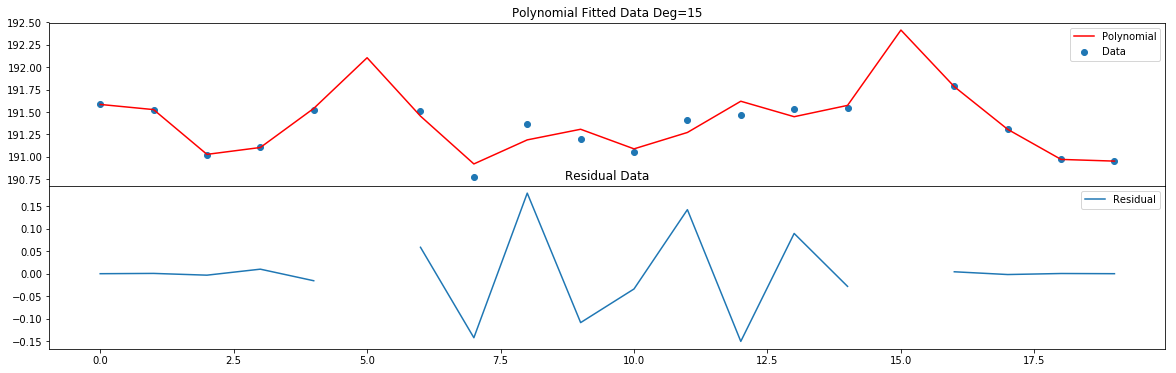

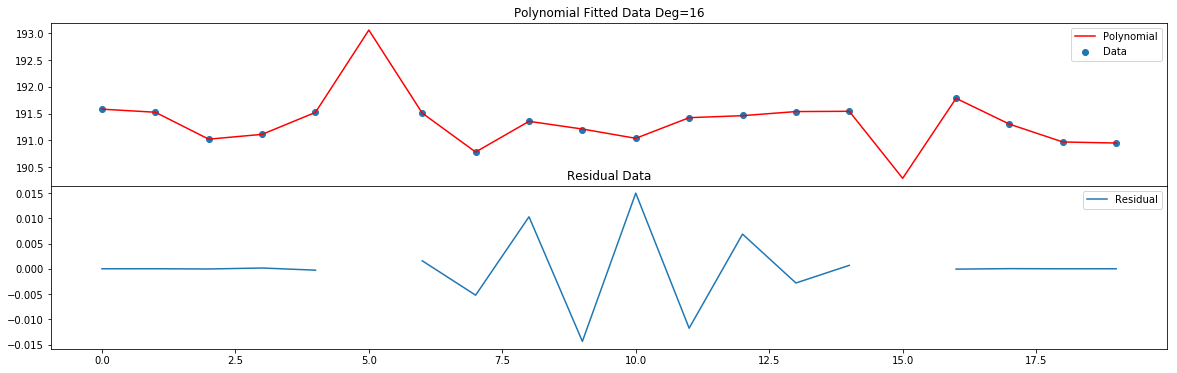

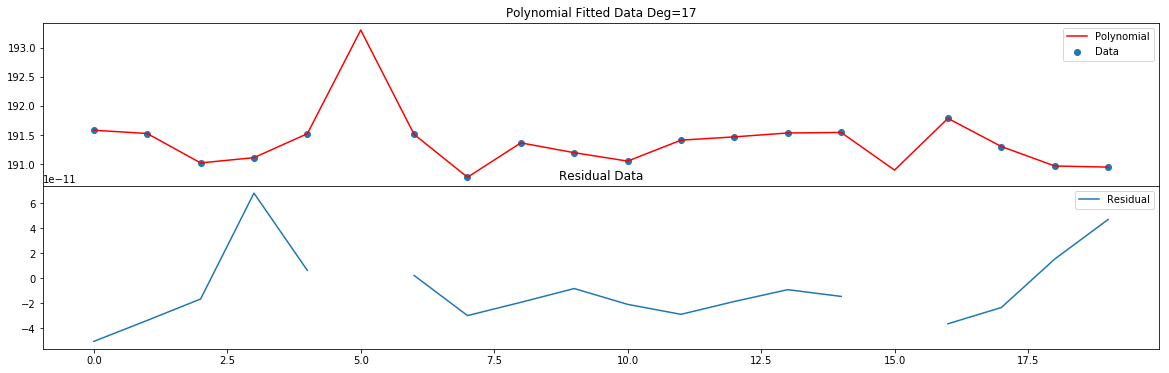

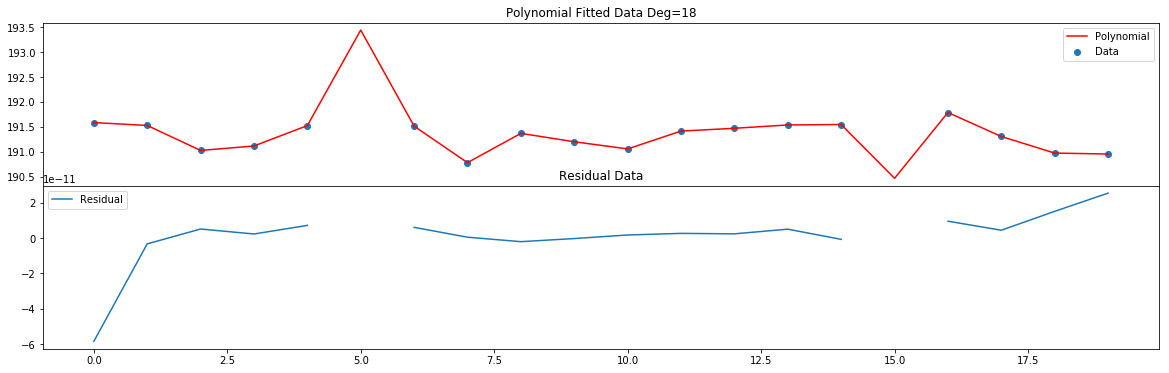

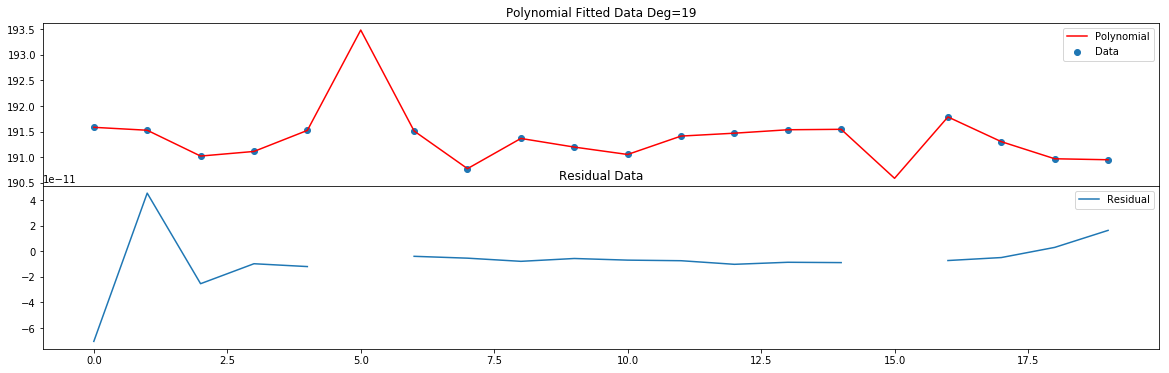

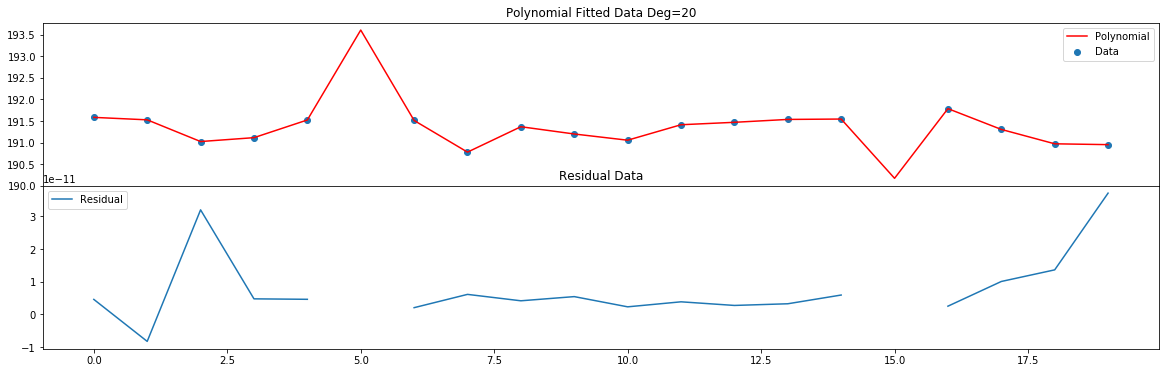

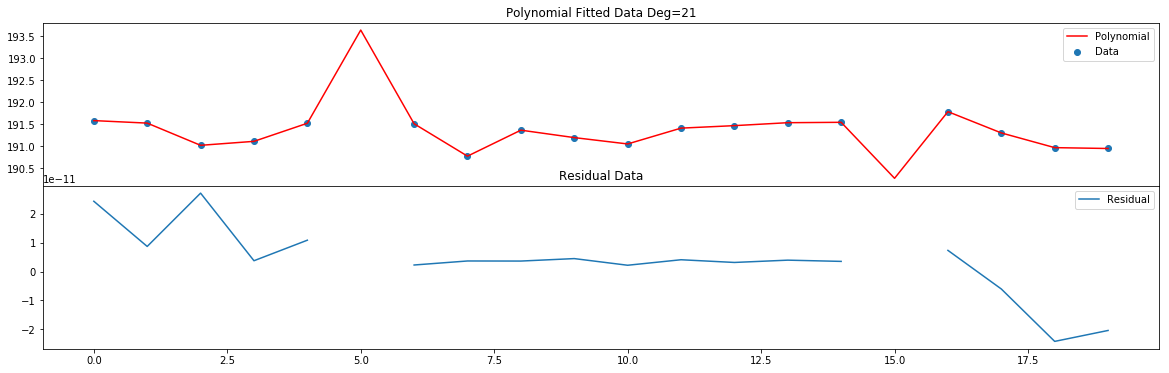

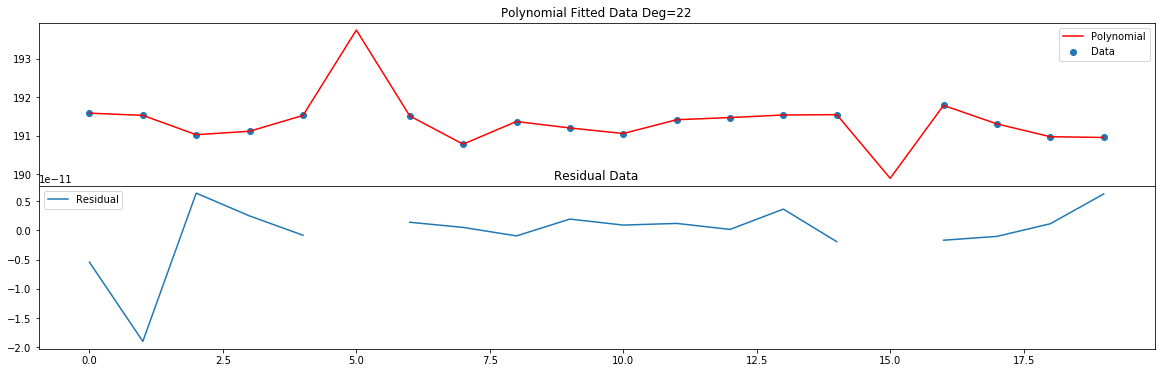

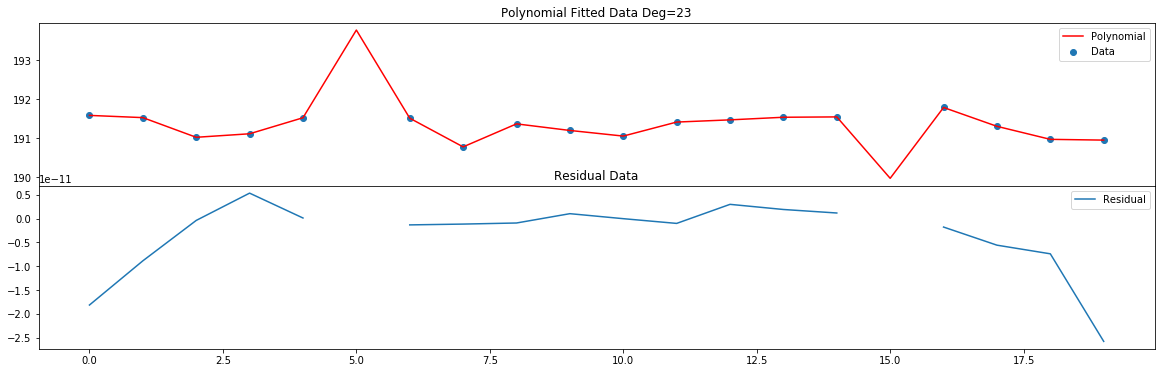

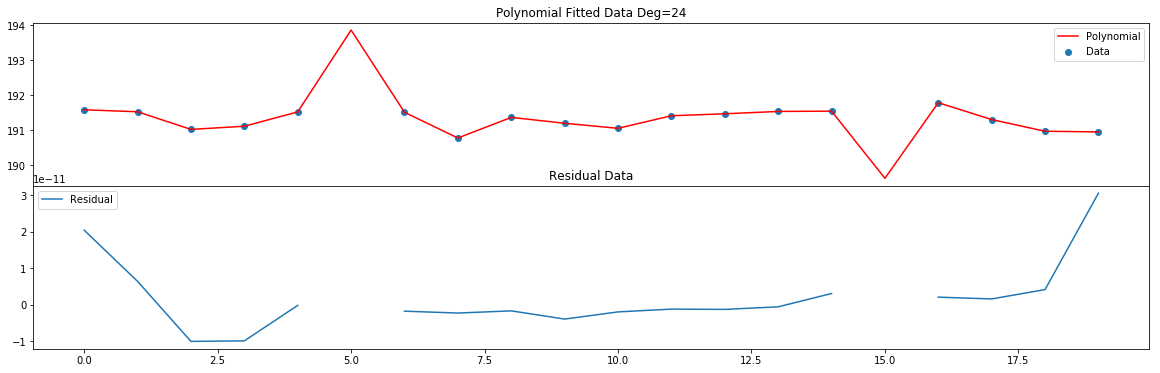

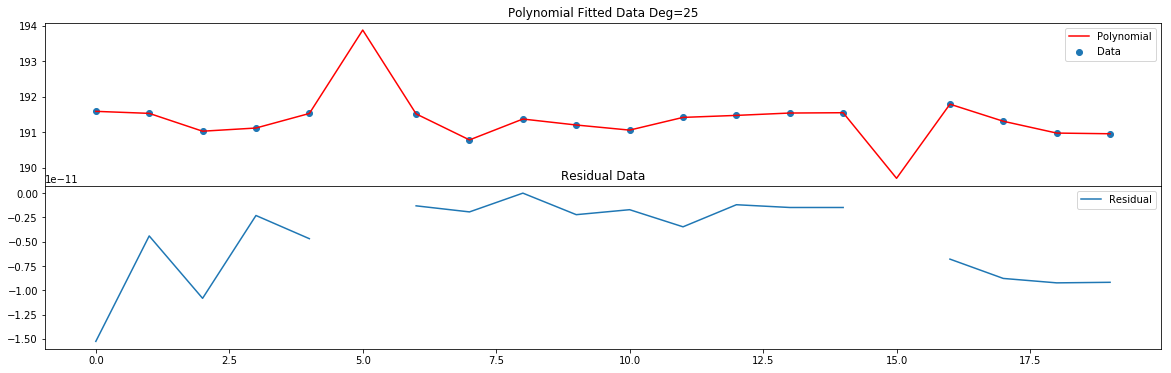

In [116]:
for deg in degree:
    p = Polynomial.fit(x, y, deg=deg)
    #r_score = r2_score(data, p(datapoints))
    r2 = calculate_r2(data, p(datapoints))
    print(f"R2 score = {r2} for deg:{deg}")
    #print(f"R2_score ={r_score} for deg:{deg}")
    fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
    fig.subplots_adjust(hspace=0)

    ax[0].scatter(datapoints, data, marker='o', label='Data')
    ax[0].plot(datapoints, p(datapoints), color='r', label='Polynomial')
    ax[0].legend()
    ax[0].title.set_text(f'Polynomial Fitted Data Deg={deg}')
    ax[1].plot(datapoints, data-p(datapoints), label='Residual')
    ax[1].title.set_text('Residual Data')
    ax[1].legend()


In [61]:
p(datapoints)

array([191.58406067, 191.52711487, 191.02377319, 191.11369324,
       191.52383423, 193.87704628, 191.51231384, 190.77838135,
       191.36714172, 191.19871521, 191.0546875 , 191.41329956,
       191.46968079, 191.53646851, 191.54527283, 189.69525732,
       191.78657532, 191.30450439, 190.97111511, 190.95176697])

In [69]:
mean_values = np.nanmean(data, axis=0)
data = np.nan_to_num(data, nan=mean_values)

In [70]:
data

array([191.58406067, 191.52711487, 191.02377319, 191.11369324,
       191.52383423, 191.31457774, 191.51231384, 190.77838135,
       191.36714172, 191.19871521, 191.0546875 , 191.41329956,
       191.46968079, 191.53646851, 191.54527283, 191.31457774,
       191.78657532, 191.30450439, 190.97111511, 190.95176697])

In [71]:
data- p(datapoints)

array([-4.65819528e-05,  5.93197835e-04, -3.29409101e-03,  1.00085631e-02,
       -1.56384061e-02, -7.90392249e-01,  5.85164245e-02, -1.41941605e-01,
        1.78538309e-01, -1.08434276e-01, -3.38732215e-02,  1.41930705e-01,
       -1.50065728e-01,  8.91645311e-02, -2.81483764e-02, -1.09936660e+00,
        4.22227743e-03, -1.88660560e-03,  3.87746944e-04, -3.28636805e-05])

In [72]:
r_score = r2_score(data, p(datapoints))

In [73]:
r_score

-0.4962427755663117

In [72]:
#difference between first and last timestep

difference

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


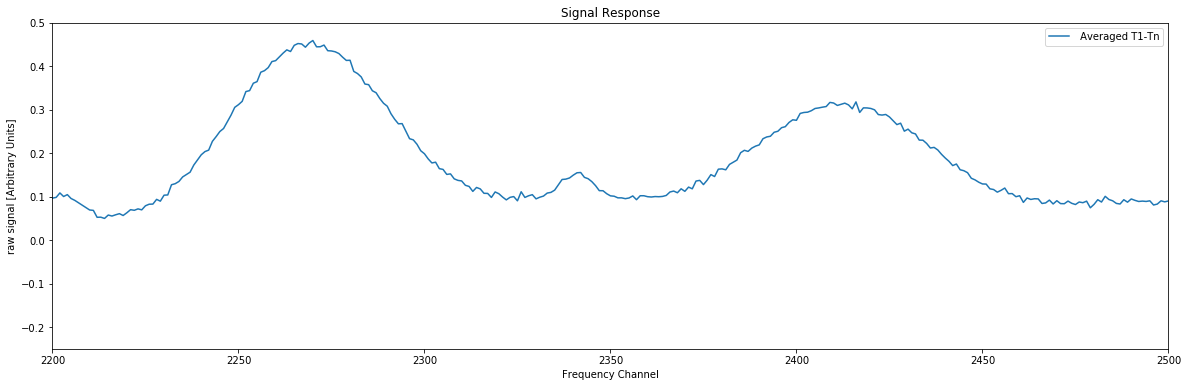

In [111]:
plt.figure(figsize=(20,6))
plt.title('Signal Response')
plt.plot(np.nanmean(difference, axis=0), label=' Averaged T1-Tn')
plt.xlabel('Frequency Channel')
plt.ylabel('raw signal [Arbitrary Units]')
plt.xlim(2200,2500)
plt.ylim(-0.25,0.5)
plt.legend()


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


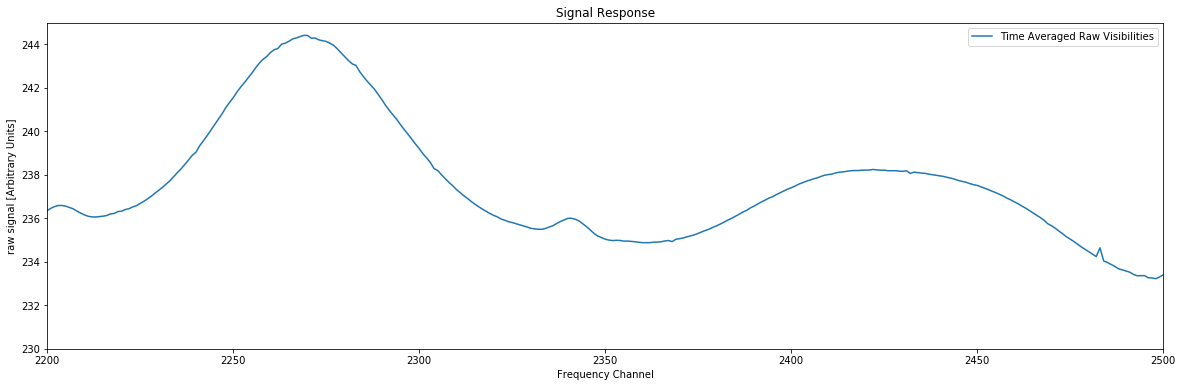

In [112]:
plt.figure(figsize=(20,6))
plt.title('Signal Response')
plt.plot(np.nanmean(x, axis=0), label='Time Averaged Raw Visibilities')
plt.xlabel('Frequency Channel')
plt.ylabel('raw signal [Arbitrary Units]')
plt.xlim(2200,2500)
plt.ylim(230,245)
plt.legend()


In [91]:
#ABBA Sky-subtraction method

ss_abba = abba(data_masked.filled())

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


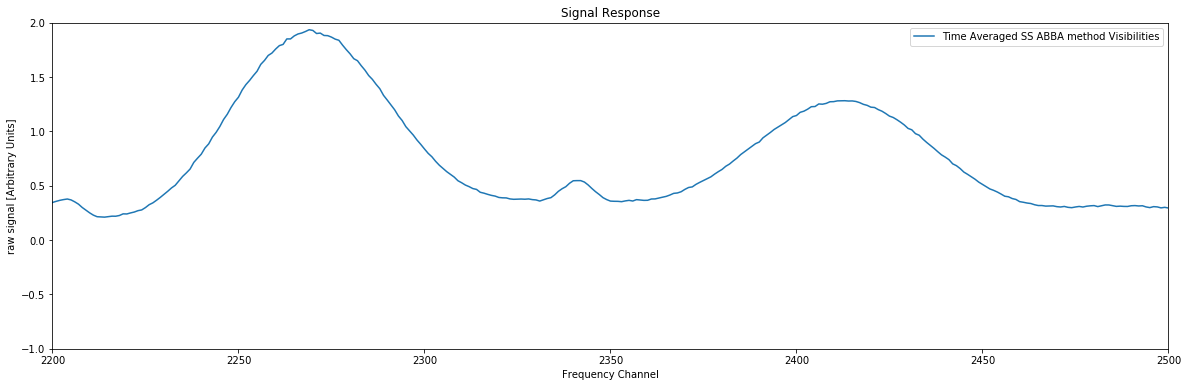

In [109]:
plt.figure(figsize=(20,6))
plt.title('Signal Response')
plt.plot(np.nanmean(ss_abba, axis=0), label='Time Averaged SS ABBA method Visibilities')
plt.xlabel('Frequency Channel')
plt.ylabel('raw signal [Arbitrary Units]')
plt.xlim(2200,2500)
plt.ylim(-1,2)
plt.legend()


In [6]:
x =data_masked.filled()


In [99]:
#Time differenced visibilities

ss_vis = SkySubtraction(data_masked)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


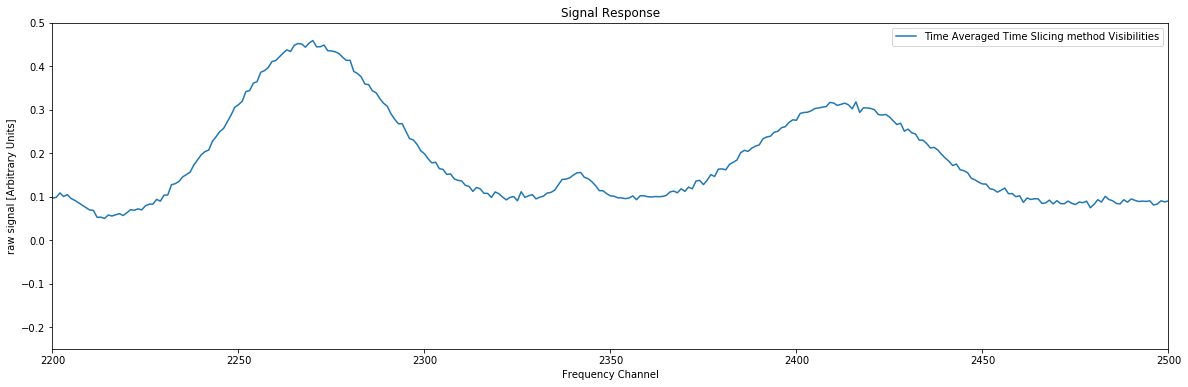

In [108]:
plt.figure(figsize=(20,6))
plt.title('Signal Response')
plt.plot(np.nanmean(ss_vis, axis=0), label='Time Averaged Time Slicing method Visibilities')
plt.xlabel('Frequency Channel')
plt.ylabel('raw signal [Arbitrary Units]')
plt.xlim(2200,2500)
plt.ylim(-0.25,0.5)
plt.legend()


In [ ]:
#Spline interpolation

x = data_masked.filled()
x = x[:1000, 3001]
xpoints = np.arange(len(x))

from scipy.interpolate import interp1d
linear = interp1d(xpoints, x, kind='linear')


#polynomial fit data
plt.figure(figsize=(20,6))
plt.plot(x, label='Raw Data freq = 3000 mhz')
#plt.plot(xpoints,polytest(xpoints), label='Polynomial')
plt.plot(xpoints, linear(xpoints), 'o-', label='Linear Interpolation')
plt.xlabel('Timestamps')
plt.ylabel('Frequency Data')
plt.ylim(190,195)
plt.xlim(400, 600)
plt.legend()
plt.show()

In [ ]:
x = data_masked[:,3001].filled()

#Polynomial fitting handling the nans
from numpy.polynomial import Polynomial

xdatapoints = np.arange(len(x))
valid_data = np.isfinite(x)

Y = x[valid_data]
X = xdatapoints[valid_data]

x.shape
p = Polynomial.fit(X, Y, deg=100000)

/usr/local/lib/python3.6/dist-packages/numpy/polynomial/polynomial.py:749: RuntimeWarning: overflow encountered in multiply
  c0 = c[-i] + c0*x


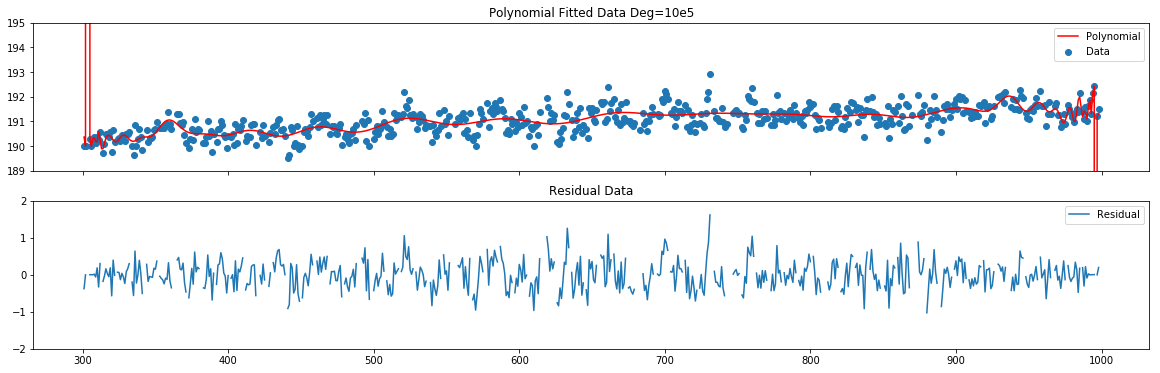

In [50]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.2)

ax[0].scatter(xdatapoints, x, marker='o', label='Data')
ax[0].plot(xdatapoints, p(xdatapoints), color='r', label='Polynomial')
ax[0].set_ylim(189,195)
ax[0].legend()
ax[0].title.set_text('Polynomial Fitted Data Deg=10e5')
ax[1].plot(xdatapoints, x-p(xdatapoints), label='Residual')
ax[1].title.set_text('Residual Data')
ax[1].set_ylim(-2,2)
ax[1].legend()



In [100]:
r_score = r2_score(data, p(xdatapoints))
r_score

0.4013426522602557

In [ ]:
#check the accuracy of a models fit to the data



In [ ]:
x1 = data_masked[:,3001].filled()

#Polynomial fitting handling the nans
from numpy.polynomial import Polynomial

x1datapoints = np.arange(len(x1))
valid_data = np.isfinite(x1)

Y1 = x1[valid_data]
X1 = x1datapoints[valid_data]
p = Polynomial.fit(X1, Y1, deg=10000000)

fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.2)

ax[0].scatter(x1datapoints, x1, marker='o', label='Data')
ax[0].plot(x1datapoints, p(x1datapoints), color='r', label='Polynomial')
ax[0].set_ylim(189,200)
ax[0].legend()
ax[0].title.set_text('Polynomial Fitted Data Deg=10e5')
ax[1].plot(x1datapoints, x1-p(x1datapoints), label='Residual')
ax[1].title.set_text('Residual Data')
ax[1].set_ylim(-2,2)
ax[1].legend()



In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline

x = data_masked[:,3001].filled()

xdatapoints = np.arange(len(x))
valid_data = np.isfinite(x)

X = x[valid_data]
Y = xdatapoints[valid_data]
sp = splrep(xdatapoints[valid_data], x[valid_data], s=len(x))

#spline fitted data
y = BSpline(*sp)(xdatapoints)

In [44]:
y[1010:1030]

array([191.66266495, 191.66471632, 191.66676912, 191.66882336,
       191.67087903, 191.67293613, 191.67499468, 191.67705466,
       191.67911608, 191.68117895, 191.68324326, 191.68530901,
       191.68737621, 191.68944486, 191.69151496, 191.69358651,
       191.69565951, 191.69773397, 191.69980989, 191.70188726])

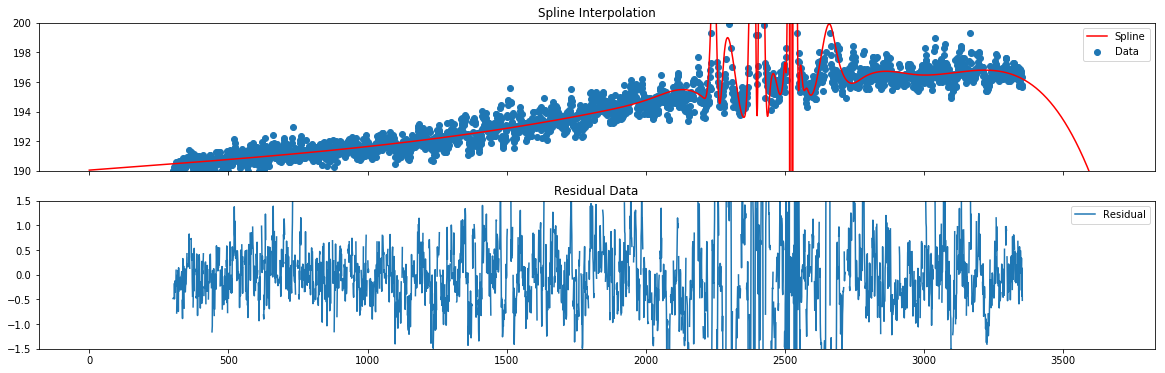

In [45]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
fig.subplots_adjust(hspace=0.2)

ax[0].scatter(xdatapoints, x, marker='o', label='Data')
ax[0].plot(xdatapoints, BSpline(*sp)(xdatapoints), color='r', label='Spline')
ax[0].set_ylim(190,200)
ax[0].legend()
ax[0].title.set_text('Spline Interpolation')
ax[1].plot(xdatapoints, x-BSpline(*sp)(xdatapoints), label='Residual')
ax[1].title.set_text('Residual Data')
ax[1].set_ylim(-1.5,1.5)
ax[1].legend()


In [35]:
#residual data
residual  =  x-y
residual[1010:1030]

array([-0.07860428, -0.13760145, -0.64299593, -0.55513012, -0.1470448 ,
               nan, -0.16268083, -0.89867331, -0.31197436, -0.48246374,
       -0.62855576, -0.27200945, -0.21769542, -0.15297635, -0.14624213,
               nan,  0.0909158 , -0.39322958, -0.72869477, -0.75012029])

In [51]:
r = x-linear(xdatapoints)

In [52]:
r[1010:1030]

array([], dtype=float64)

In [167]:
r[1010:1030]

array([ 0.,  0.,  0.,  0.,  0., nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., nan, nan,  0.,  0.,  0.])

In [87]:
# savitzky_golay polynomial fit
from scipy import signal
x = data_masked[:,:].filled()
xdatapoints = np.arange(len(x))
valid_data = np.isfinite(x)
fit =  signal.savgol_filter(x, 3, 1)

In [88]:
fit.shape

(3647, 4096)

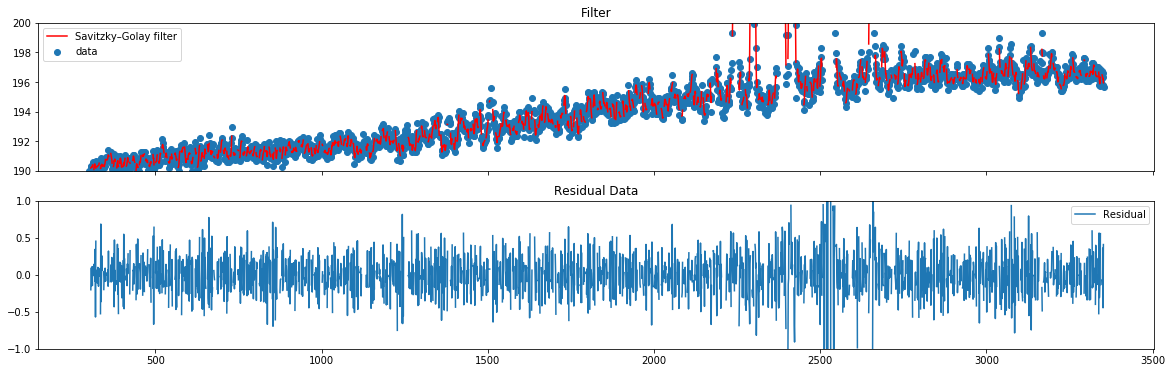

In [10]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.2)
ax[0].scatter(xdatapoints, x, label='data')
ax[0].plot(xdatapoints, fit, color='r', label='Savitzky–Golay filter')
ax[0].set_ylim(190,200)
ax[0].legend()
ax[0].title.set_text('Filter')
ax[1].plot(xdatapoints, x-fit, label='Residual')
ax[1].title.set_text('Residual Data')
ax[1].set_ylim(-1,1)
ax[1].legend()


In [46]:
fit[1010:1030]

array([191.37795003, 191.37831624, 191.2215271 , 191.22043355,
                nan,          nan,          nan, 191.21927897,
       191.11474609, 191.20684814, 191.22223409, 191.31255595,
       191.47314962, 191.51714071,          nan,          nan,
                nan, 191.35406494, 191.07579549, 191.14017232])

In [58]:
y =x-fit

In [60]:
y[1010:1030,3001]

array([ 0.53811646,  0.1790212 ,  0.09317017, -0.00828552,  0.18070984,
               nan,  0.19932556, -0.45710246,  0.08457438, -0.11099752,
       -0.1751709 , -0.18195089, -0.19035848,  0.03801473,  0.22289022,
               nan,  0.48867798,  0.00952657, -0.18905131, -0.21893311])

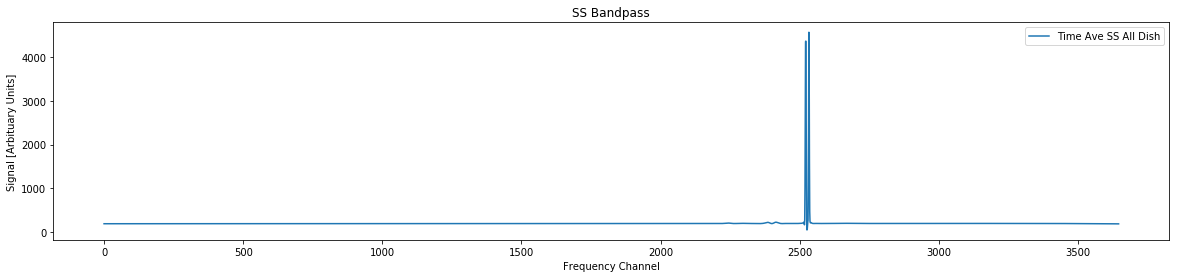

In [92]:
plt.figure(figsize =(20,4))
plt.title('SS Bandpass')
plt.xlabel('Frequency Channel')
plt.ylabel('Signal [Arbituary Units]')
plt.plot(y, label = 'Time Ave SS All Dish')
#plt.xlim(2500, 2600)
plt.legend()


In [56]:
x.shape

(3647,)

In [6]:
#ABBA Method

x = data_masked[:,:].filled()

ss_abba = abba(x)

In [63]:
ss_abba.shape

(3644, 4096)

In [ ]:
# Time Slcing Bandpass



/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


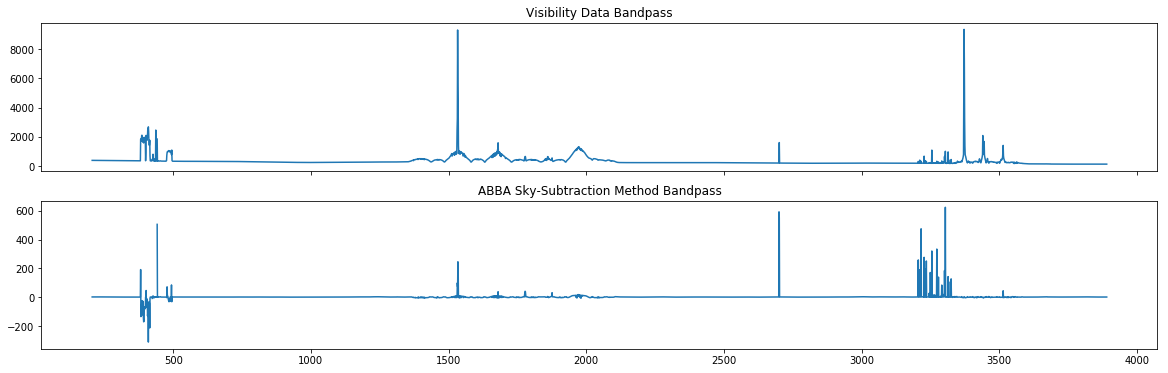

In [99]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
fig.subplots_adjust(hspace=0.2)
ax[1].plot(np.nanmean(ss_abba, axis=0))
#ax[1].legend()
ax[1].title.set_text('ABBA Sky-Subtraction Method Bandpass')
ax[0].title.set_text('Visibility Data Bandpass')
ax[0].plot(np.nanmean(x, axis=0))
#ax[0].legend()

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: Mean of empty slice


(2200, 2500)

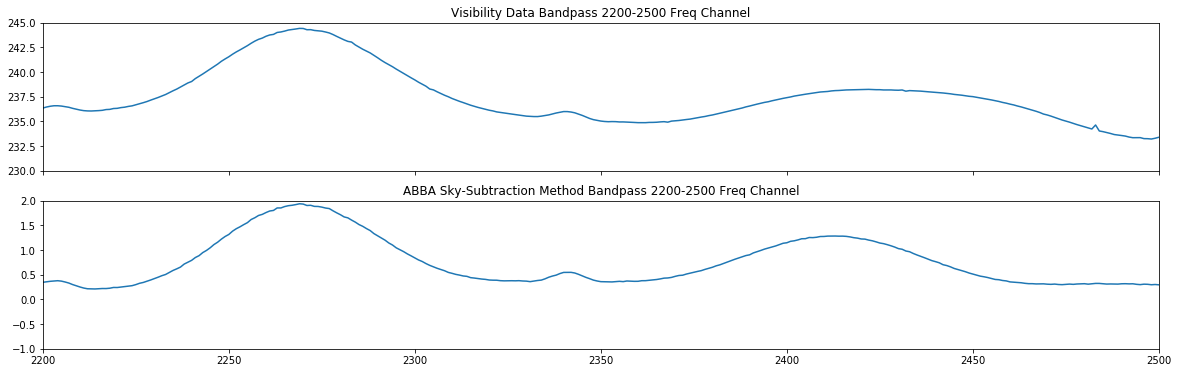

In [98]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
fig.subplots_adjust(hspace=0.2)
ax[1].plot(np.nanmean(ss_abba, axis=0))
ax[1].set_ylim(-1,2)
ax[1].set_xlim(2200, 2500)
#ax[1].legend()
ax[1].title.set_text('ABBA Sky-Subtraction Method Bandpass 2200-2500 Freq Channel')
ax[0].title.set_text('Visibility Data Bandpass 2200-2500 Freq Channel')
ax[0].plot(np.nanmean(x, axis=0))
ax[0].set_ylim(230,245)
ax[0].set_xlim(2200, 2500)
#ax[0].legend()

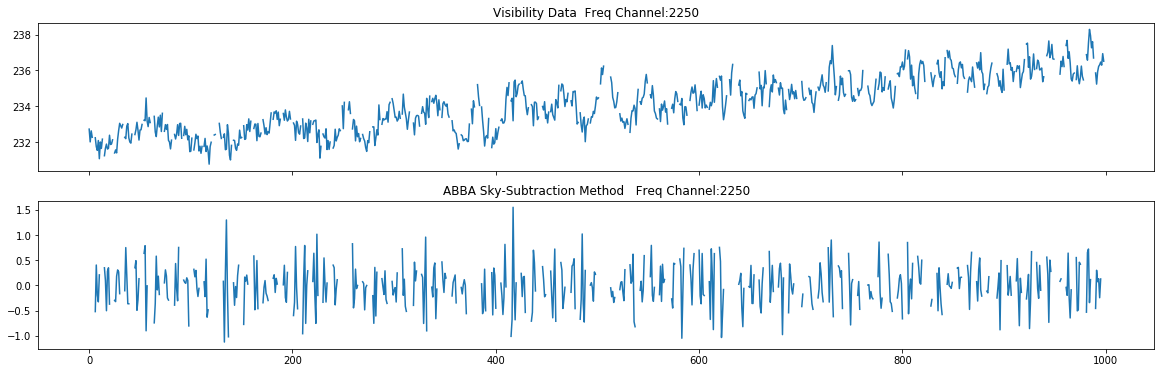

In [108]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
fig.subplots_adjust(hspace=0.2)
ax[1].plot(ss_abba[1001:2001, 2250])
#ax[1].set_ylim(-1,2)
ax[1].title.set_text('ABBA Sky-Subtraction Method   Freq Channel: 2250')
ax[0].title.set_text('Visibility Data  Freq Channel: 2250')
ax[0].plot(x[1001:2001, 2250])
#ax[0].set_ylim(230,245)

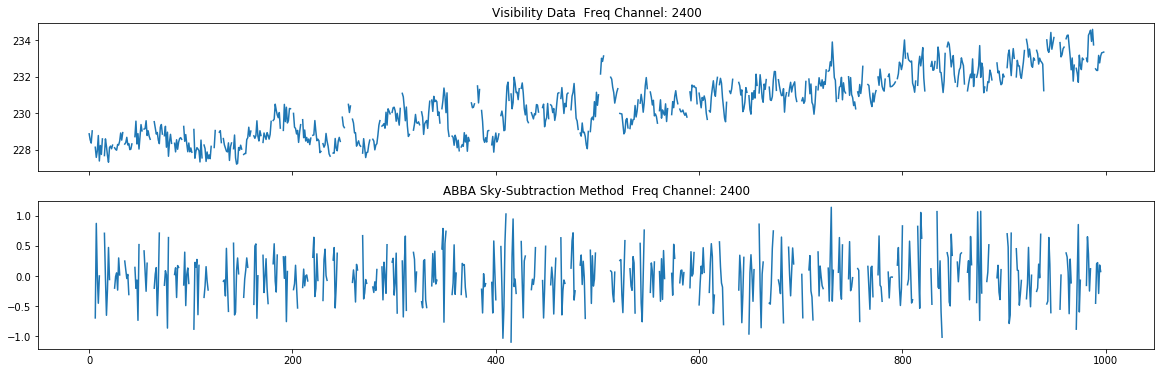

In [109]:
fig, ax = plt.subplots(2, 1, sharex=True,  figsize=(20,6))
fig.subplots_adjust(hspace=0.2)
ax[1].plot(ss_abba[1001:2001, 2400])
#ax[1].set_ylim(-1,2)
ax[1].title.set_text('ABBA Sky-Subtraction Method  Freq Channel: 2400')
ax[0].title.set_text('Visibility Data  Freq Channel: 2400')
ax[0].plot(x[1001:2001, 2400])
#ax[0].set_ylim(230,245)

In [33]:
#2D Spline FIt
x = data_masked[:,:].filled()


In [41]:
ss_vis = SkySubtraction(x)
ss_vis[:, 3001].shape

(3646,)

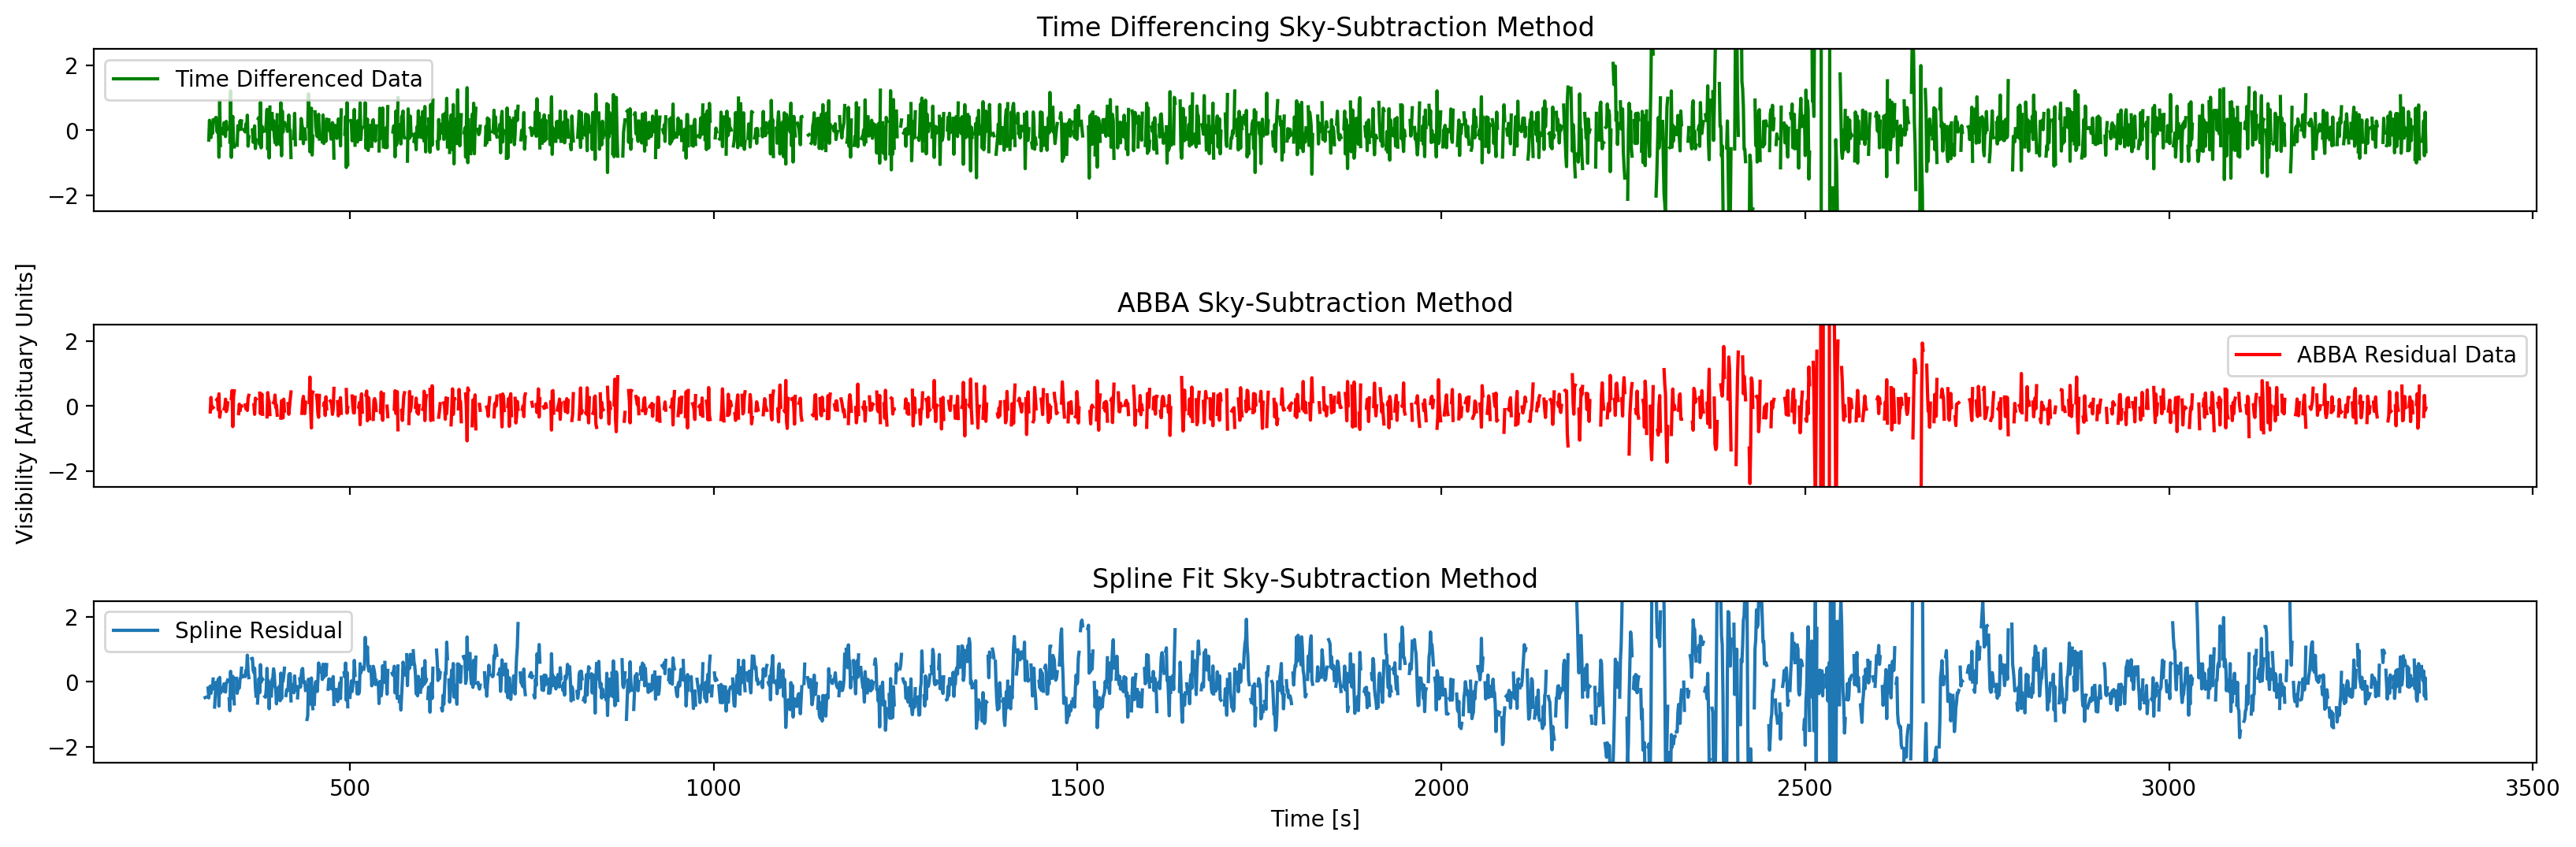

In [65]:
fig, ax = plt.subplots(3, 1, sharex=True,  figsize=(20,6),  dpi=200)
fig.subplots_adjust(hspace=0.7)

ax[1].plot(xdatapoints[3:], ss_abba[:,3001], color='r', label='ABBA Residual Data' ) #had to truncate x points for plotting to match ss_abba.shape of (3644,)
ax[1].set_ylim(-2.5,2.5)
ax[1].title.set_text('ABBA Sky-Subtraction Method')
ax[1].set_ylabel(' Visibility [Arbituary Units]')
ax[1].legend()

ax[2].title.set_text('ABBA Sky-Subtraction Method')
ax[2].plot(xdatapoints, x-BSpline(*sp)(xdatapoints), label='Spline Residual') #for channel 3001 aswell
ax[2].title.set_text('Spline Fit Sky-Subtraction Method')
ax[2].set_ylim(-2.5,2.5)
ax[2].set_xlabel('Time [s]')
ax[2].legend()

ax[0].plot(xdatapoints[1:], ss_vis[:,3001], label='Time Differenced Data', color='g') #for channel 3001 aswell
ax[0].title.set_text('Time Differencing Sky-Subtraction Method')
ax[0].set_ylim(-2.5,2.5)
ax[0].legend()

plt.savefig('ABBA-Spline Residual Comparison.png', bbox_inches='tight')



In [10]:
xdatapoints.shape

(3647,)

In [191]:
ss_abba = abba(x)

In [192]:
ss_abba.shape

(3644, 4096)

In [139]:
x = data_masked[:,:].filled()
xdatapoints

array([   0,    1,    2, ..., 3644, 3645, 3646])

In [6]:
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline

x = data_masked[:,3001].filled()

xdatapoints = np.arange(len(x))
valid_data = np.isfinite(x)

X = x[valid_data]
Y = xdatapoints[valid_data]
sp = splrep(xdatapoints[valid_data], x[valid_data], s=len(x))

#spline fitted data
y = BSpline(*sp)(xdatapoints)

yres = x -y
yres = yres[2000:3000]

In [65]:
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline

x = data_masked[:,3001].filled()
#x_trimmed = x_trimmed[:,3001]
xdatapoints = np.arange(len(x_trimmed))
valid_data = np.isfinite(x_trimmed)

X = x_trimmed[valid_data]
Y = xdatapoints[valid_data]
sp = splrep(xdatapoints[valid_data], x_trimmed[valid_data], s=len(x_trimmed))

#spline fitted data
y = BSpline(*sp)(xdatapoints)

yres = x_trimmed -y


In [54]:
# Trimming of 2000:3000

x_trimmed = np.concatenate((x[:2000], x[3001:]))

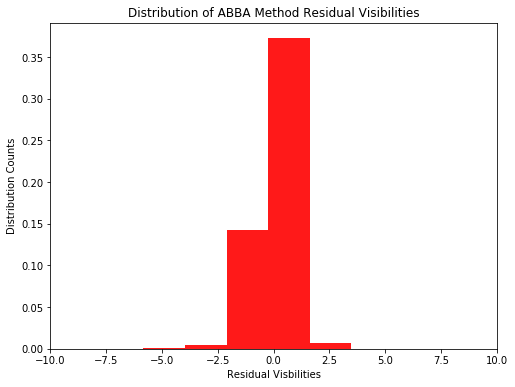

In [81]:
x = data_masked[:,:].filled()
ss_abba = abba(x_trimmed)

plt.figure(figsize=(8, 6))
plt.hist(ss_abba[~np.isnan(ss_abba)], bins=1500, alpha=0.9, density=True, color='r')
plt.ylabel('Distribution Counts')  
plt.xlabel('Residual Visbilities')
plt.title('Distribution of ABBA Method Residual Visibilities')  
plt.xlim(-10,10)
plt.show()


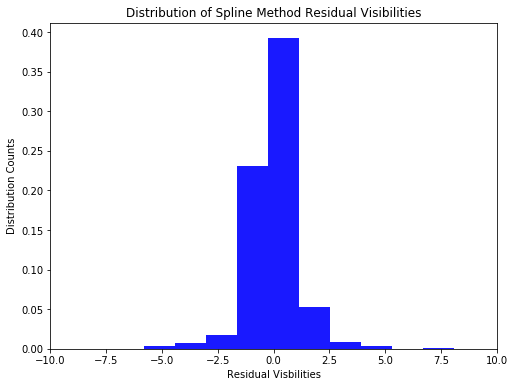

In [80]:
plt.figure(figsize=(8, 6))
plt.hist(yres[~np.isnan(yres)], bins=10, alpha=0.9, density=True, color='b')
plt.ylabel('Distribution Counts') 
plt.xlabel('Residual Visbilities')
plt.title('Distribution of Spline Method Residual Visibilities')  
plt.xlim(-10,10)
plt.show()
